In [ ]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]


(1450, 400)
(400, 400)
coherence of data:  0.7119395644427655


In [ ]:
#Raw data training
starttime=time.time()
target='raw'
labeled_data=2000
layer_loss_list=[]
Epochs=10
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128
layers=[5000,5000, 5000, 3000, 3000, 4000,8000]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
valloader=DataLoader(val_data,batch_size=512,shuffle=True,num_workers=4)
encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        if labeled_data==1:
            b=b.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)  
            rho=rho.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)
        font_size = 50
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid':
            #rho_hat=rho_hat-rho
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        if encoder_out=='sigmoid' or encoder_out=='softmax':
            #print(rho_hat.shape, rh.shape)
            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            bce_loss.backward() 
            train_lossavg+=bce_loss.item()/len(trainloader)

        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            L2_loss.backward()
            train_lossavg+=L2_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    wand_dict['train loss']=train_lossavg
    val_loss=0
    encoder.eval()
    for batch, (b,rho,num_targets) in enumerate(valloader):
        b=b.to(device)
        rho=rho.to(device)    
        font_size = 50
        rho_hat=encoder(b)
        if encoder_out=='sigmoid':
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid' or encoder_out=='softmax':

            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            val_loss+=bce_loss.item()/len(valloader)
        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            val_loss+=L2_loss.item()/len(valloader)
    wand_dict['val loss']=val_loss
    if epoch==Epochs-1:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    if Track_run:
        wandb.log(wand_dict)

if Track_run:
    wandb.finish()


In [39]:
#Raw data training unlabeled only
starttime=time.time()
target='raw'
unlabeled_data=40000
batchsize=128
L1_weight=1e-10
layers=[500,500,500,300,300,400,800]
#layers.append(256)
GELMA_layers=[500,500,500,300,300,400,800]
CE=False
KM_in=False
#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=1000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim*2


encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            medium_hat=decoder(Complex_eye).squeeze()
            medium_hat=F.normalize(medium_hat, dim=-1)
            Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
            
            b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
            km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
            km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

            km_b=torch.cat((km_b_real, km_b_imag), dim=-1)
            
            print(b.shape, km_b.shape,km_b_real.shape, medium_hat.shape)
            In_put=torch.cat((b, km_b), dim=-1)



            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if KM_in:
                rho_hat=encoder(In_put)
            else:
                rho_hat=encoder(b)
            rho_hat=sigmoid(rho_hat)
            b_hat=decoder(rho_hat)
            rho_hat_hat=encoder(b_hat)

            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss=L1_loss.item()/L1_weight
            else:
                L1_loss=-1

            if CE:
                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
                CEloss.backward(retain_graph=True)
                CEloss=CEloss.item()

            
            if GELMA>0 and epoch>100:
                optimizer_GELMA.zero_grad()
                GELMA_out=GELMA_net(b)
                GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
                inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
                inner_loss_term.backward(retain_graph=True)
                inner_loss_term_avg=inner_loss_term.item()/GELMA
                optimizer_GELMA.step()
                
            else:
                inner_loss_term_avg=-1
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()


            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (40000, 400), B: (40000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
8281000
Data shapes: 1450.0 200.0
torch.Size([128, 2900]) torch.Size([400, 256]) torch.Size([400, 128]) torch.Size([400, 2900])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 128 but got size 400 for tensor number 1 in the list.

Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
11046400
Data shapes: 1450.0 200.0


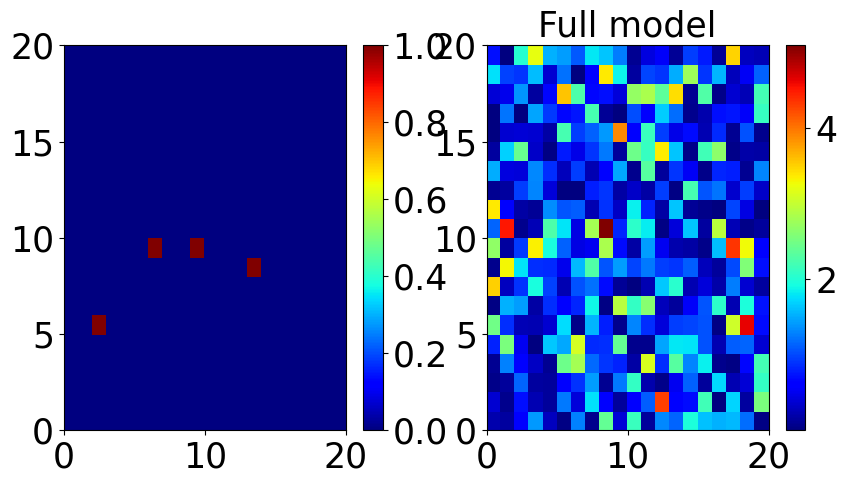

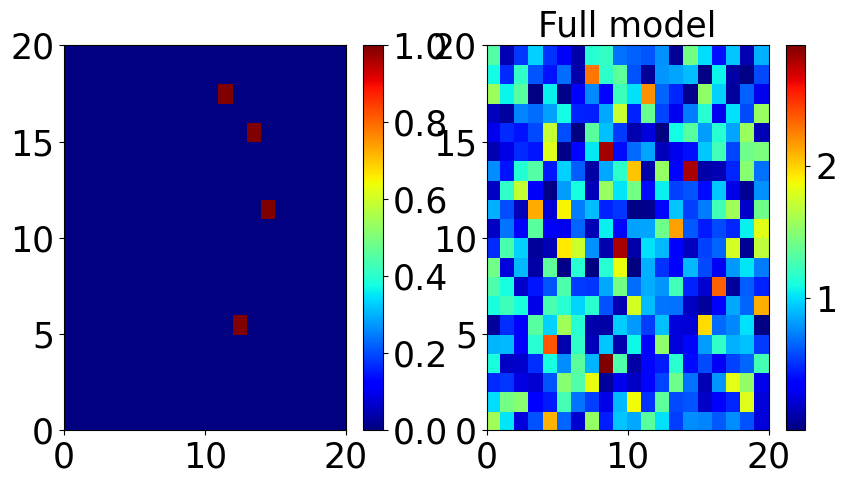

epoch: 0, train loss: 0.5128243193030357, KL_LOSS: 185920.2484375, val loss: 0.039056263864040375, max avg inners: 0.02431056092551005,  num indices: 0
epoch: 1, train loss: 0.0896213211119175, KL_LOSS: 126730.4671875, val loss: 0.03776675462722778, max avg inners: 0.03329611467655931,  num indices: 0
epoch: 2, train loss: 0.05555113591253757, KL_LOSS: 87099.29257812498, val loss: 0.037269044667482376, max avg inners: 0.04939327193757353,  num indices: 0
epoch: 3, train loss: 0.04503376781940461, KL_LOSS: 58947.5921875, val loss: 0.03705944865942001, max avg inners: 0.06510444640738919,  num indices: 0
epoch: 4, train loss: 0.0408379141241312, KL_LOSS: 38984.0875, val loss: 0.03696969524025917, max avg inners: 0.07305109542838405,  num indices: 0
epoch: 5, train loss: 0.03950601965188981, KL_LOSS: 25000.966406249998, val loss: 0.036939457058906555, max avg inners: 0.0754046671508731,  num indices: 0
epoch: 6, train loss: 0.03910431340336799, KL_LOSS: 17031.8630859375, val loss: 0.03697

KeyboardInterrupt: 

In [26]:
#Raw data training variational autoencoder (KL replcaed with BCE)
starttime=time.time()
target='raw'
unlabeled_data=5000
batchsize=128
layers=[500,500,500,300,300,300,400,800]
G_0=False
Epochs=10000
index_list=[]
KL_weight=1
L1_weight=1e-3

Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=512
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)

encoder=M.variational_enc(training_data.b[0].shape[0]/2, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
decoder=M.fc_net_extra(outdim, [layers[len(layers)-i-1] for i in range(len(layers))],training_data.b[0].shape[0]/2 , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)

if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
L1_loss_fn=nn.L1Loss()
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)

lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    encoder.train()
    decoder.train()
    KL_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        b=b.to(device)
        rho=rho.to(device)

        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        rho_hat_mean, rho_hat_logvar=encoder(b)
        rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
        KLloss=H.KL_divergence(rho_hat_mean, rho_hat_logvar)*KL_weight
        KLloss.backward(retain_graph=True)
        #rho_hat=sigmoid(rho_hat)

        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss=L1_loss.item()/L1_weight
        else:
            L1_loss=-1

        b_hat=decoder(rho_hat)
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        optimizer_decod.step()
        train_lossavg+=L2_loss.item()/len(trainloader)
        KL_lossavg+=KLloss.item()/len(trainloader)/KL_weight
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat_mean, rho_hat_logvar=encoder(b_val)
    rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
    #rho_hat=softmax(rho_hat)
    #rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        #Complex_eye=Complex_eye+
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, KL_LOSS: {KL_lossavg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original},  num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [20]:
encoder


variational_enc(
  (shared): fc_net_batch(
    (dropout): Dropout(p=0.5, inplace=False)
    (layers): ModuleList(
      (0): linear_layer_wrapper(
        (layer): Sequential(
          (0): Linear(in_features=2900, out_features=1000, bias=True)
          (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.5, inplace=False)
        )
      )
      (1): linear_layer_wrapper(
        (layer): Sequential(
          (0): Linear(in_features=1000, out_features=1000, bias=True)
        )
      )
    )
    (sigmoid): Sigmoid()
    (softmax): Softmax(dim=-1)
  )
  (enc_mean): fc_net_batch(
    (dropout): Dropout(p=0.5, inplace=False)
    (layers): ModuleList(
      (0): linear_layer_wrapper(
        (layer): Sequential(
          (0): Linear(in_features=1000, out_features=1000, bias=True)
          (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
      

In [ ]:
#Raw data training unlabeled only. Encoder decoder alternation
starttime=time.time()
target='raw'
unlabeled_data=10000
L1_weight=0.005
GELMA=0.0
G_0=False
Epochs=100000
layers=[128]*14
GELMA_layers=[128]*5
GELMA_layers.append(500)
layers.append(500)



Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128

#training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
b=training_data.b.to(device)
rho=training_data.rho.to(device)
rh_t, _=torch.split(rho, 400, dim=-1)


#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)

encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.Adam(decoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)

if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.AdamW(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()


for epoch in range(Epochs):
    encoder.train()
    decoder.train()
    train_lossavg=0
    train_lossavg=0
    train_lossavg_decoder=0
    inner_loss_term_avg=0
    L1_loss_avg=0
    for param in encoder.parameters():
        param.requires_grad = True
    for i in range(15):
        optimizer.zero_grad()
        optimizer_decod.zero_grad()


        font_size = 50
        rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)
        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss_avg+=L1_loss.item()/L1_weight/15
            #if L1_loss>5e-15:
                #L1_weight=L1_weight*0.999
        else:
            L1_loss=-1

        if GELMA>0:
            optimizer_GELMA.zero_grad()
            GELMA_out=GELMA_net(b)
            GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
            inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
            inner_loss_term.backward(retain_graph=True)
            inner_loss_term_avg+=inner_loss_term.item()/GELMA/15
            optimizer_GELMA.step()
        else:
            inner_loss_term_avg=-1
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


    
        optimizer.step()
        train_lossavg+=L2_loss.item()/15
    for param in encoder.parameters():
        param.requires_grad = False


    for i in range(15):
        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        font_size = 50
        rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)


        
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()



        optimizer_decod.step()
        train_lossavg_decoder+=L2_loss.item()/15
    
    
    val_lossavg=0
    if epoch%1000==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%1000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%100==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
            index_of_max=np.argmax(torch_inners[:,i])
            torch_inners[:,index_of_max]=0*torch_inners[index_of_max,:]
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        
        
        
        print(f'epoch: {epoch}, Encoder train loss: {train_lossavg}, Decoder train loss: {train_lossavg_decoder} L1 loss: {L1_loss_avg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}')
        
    if Track_run:
        wandb.log(wand_dict)


if Track_run:
    wandb.finish()


In [ ]:
#cc data training
starttime=time.time()
target='raw'
labeled_data=400
layer_loss_list=[]
Epochs=10000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
width=512
num_layers=11
layers=[250,1000,750,500, 500, 300, 300, 400,800]

training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1, medium='Homogenous')
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_CC(data_path+'/val', 400/80000,1)
#valloader=DataLoader(val_data,batch_size=batchsize,shuffle=True,num_workers=4)


encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0], training_data.rho[0].shape[0]/2)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.CrossEntropyLoss()   
L2_loss_fn=nn.MSELoss()


b, rho=training_data.get_data()
print(b.shape, rho.shape)
b=b.to(device)
rho=rho.to(device)
b_val, rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)
rh, _=torch.split(rho, 400, dim=-1)
rh_val, _=torch.split(rho_val, 400, dim=-1)

for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    train_acc=0
    optimizer.zero_grad()

    
    rho_hat=encoder(b)

    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    bce_loss.backward() 
    train_lossavg=bce_loss.item()
    optimizer.step()
    train_acc=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()
    #if epoch%100==0:
        #H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)
    finish=time.time()-starttime
    #print(f"time for labeled: {finish}")
    val_loss=0
    encoder.eval()
    val_acc=0
    font_size = 50
    rho_hat=encoder(b_val)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    val_loss+=bce_loss.item()
    val_acc+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rho_val.squeeze()).item()
    if epoch%100==0:
        #H.plot_2_imgs(rho_val, softmax(rho_hat.squeeze()),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)

        print(f'epoch: {epoch}, train loss: {train_lossavg}, train accuracy: {train_acc} val loss: {val_loss}, val accuracy: {val_acc}')

torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net.pt')
print(f"time for cell: {finish}")

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


In [ ]:
#loads orderer network, 'orderer' saved Decoder model located at 'locat'. Then reorderes the decoder columns into
#the variable 'G_hat_permed'. Reordering is done by placing the column with the highest probability into the correct predicted position.
#this is repeated until the entire matrix is reordered.
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#save_lcation:"/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)"
orderer.load_state_dict(torch.load(Locat_orderer))

layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
decoder=nn.Linear(400,1450*2, bias=False)
#locat="/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (00:41:20)decoder.pt"
locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' #.995 model
#locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_20000U_[500, 500, 500, 300, 300, 400, 800]_16-May-2024 (10:31:06)decoder.pt'
#locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_16-May-2024 (19:56:07)decoder.pt'
#locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_10000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (16:35:12)decoder.pt'
#locat='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (20:36:55)decoder.pt'
decoder.load_state_dict(torch.load(locat))


Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
cc_medium=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    cc_medium.append(outer)

cc_medium=np.array(cc_medium)
print(outer.shape, cc_medium.shape)
cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1)
print(cc_medium.shape)
Perm=orderer(cc_medium)

softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
T=[]
print(Perm.shape)
for i in range(len(Perm)):
    largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    Perm[:,indices_1[overall_max_index]]=0


print(G_hat_permed.shape, medium_hat.shape)

In [ ]:
#function doing above
def reorder_step(medium_hat):
    
    cc_medium=[]
    for i in range(len(medium_hat)):
        outer=np.outer(medium_hat[i],medium_hat[i].conj())
        outer=outer[abs(Mask)>0]
        outer=outer.ravel()
        cc_medium.append(outer)

    cc_medium=np.array(cc_medium)
    print(outer.shape, cc_medium.shape)
    cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1).float()
    print(cc_medium.shape)
    Perm=orderer(cc_medium)

    softmax=nn.Softmax(dim=1)
    Perm=softmax(Perm.squeeze())
    G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
    #G_hats_notremapped=[]
    for i in range(len(Perm)):
        largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
        overall_max_index=torch.argmax(largest)
        G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
        Perm[:,indices_1[overall_max_index]]=0


    return G_hat_permed

for i in range(1):
    torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
    print(sum(torch_inners.diagonal())/400)
    G_hat_permed=reorder_step(G_hat_permed)
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Permutes the columns with inerse perm matrix.
Perm=orderer(cc_medium)
softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
hope=torch.tensor(np.linalg.inv(Perm.cpu().detach().numpy())).round()
G_hat_permed_inver=medium_hat.squeeze().T@hope.cpu().detach().numpy().T
G_hat_permed_inver=torch.tensor(G_hat_permed_inver.T)
G_hat_permed_inver=F.normalize(G_hat_permed_inver, dim=-1)

torch_inners=np.abs(np.inner(G_hat_permed_inver,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Compares the behavior of different decoder networks trained with different random realizations and different
#SGD randomness. 
decoder=nn.Linear(400,1450*2, bias=False)

locat1='/home/achristie/Codes_data/Experiment_data/Init_opt_experiments/0L_20000U_[500, 500, 500, 300, 3000, 400, 800]_22-May-2024 (08:33:34)decoder.pt'
locat2='/home/achristie/Codes_data/Experiment_data/Init_opt_experiments/0L_20000U_[500, 500, 500, 300, 3000, 400, 800]_22-May-2024 (01:45:38)decoder.pt'
locat3='/home/achristie/Codes_data/Experiment_data/Init_opt_experiments/0L_20000U_[500, 500, 500, 300, 3000, 400, 800]_22-May-2024 (01:42:29)decoder.pt'
locat4='/home/achristie/Codes_data/Experiment_data/Init_opt_experiments/0L_20000U_[500, 500, 500, 300, 3000, 400, 800]_21-May-2024 (17:34:11)decoder.pt'
locat5='/home/achristie/Codes_data/Experiment_data/Init_opt_experiments/0L_20000U_[500, 500, 500, 300, 3000, 400, 800]_21-May-2024 (17:32:32)decoder.pt'


locat_list=[locat1, locat2, locat3, locat4, locat5]
locat1_indlist=[]
locat2_indlist=[]
locat3_indlist=[]
locat4_indlist=[]
locat5_indlist=[]
total_list=[locat1_indlist, locat2_indlist, locat3_indlist, locat4_indlist, locat5_indlist]
pmf_list=[]
for j in range(5):
    pmf_list.append([])
    decoder.load_state_dict(torch.load(locat_list[j]))

    Complex_eye=torch.eye(400).unsqueeze(1)
    medium_hat=decoder(Complex_eye)
    medium_hat=medium_hat.squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
    #pmf_list.append(torch_inners.diagonal)
    larger_than=0
    sum_max_noreplace_original=0
    dx=.05

    for k in range(int(1/dx)):
        
        for i in range(400):
            if max(torch_inners[i,:])>k*dx and max(torch_inners[i,:])<(k+1)*dx:
                larger_than+=1
            if dx*j>=95 and i not in total_list[j]:
                total_list[j].append(i)
            sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat
        #print(larger_than)   
        pmf_list[j].append(larger_than/400)



j = 0  # replace with your desired index

# Ensure pmf_list[j] is not empty
if pmf_list[j]:
    plt.bar([dx*j for j in range(1,21)], pmf_list[j])
    plt.title(f'PMF for index {j}')
    plt.xlabel('Outcome')
    plt.ylabel('Probability')
    plt.show()
else:
    print(f"No data available for index {j}")

In [ ]:

indices_used=[i for j in total_list for i in j]
indices_used=list(set(indices_used))
shared_inds=list(set(locat1_indlist).intersection(locat2_indlist))
len(shared_inds), ([len(locat1_indlist), len(locat2_indlist)]), len(indices_used)

In [ ]:
####Tests orderer on fully random data  
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
data_path_PNAS=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
data_path_MULTI_REAL=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 

#original_G_list= np.array(mat73.loadmat(data_path_MULTI_REAL+'/rtt_array.mat')['RM_realization_list'])
test_g=original_G_list[2]
print(original_G_list.shape)



training_data=H.data_rho_CC(data_path_PNAS+'/train',labeled_data/80000,1)

medium_index=0

medium= np.array(mat73.loadmat(data_path_PNAS+'/rtt.mat')['Artt'])
medium=test_g
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
softmax=nn.Softmax(dim=1)
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
orderer.load_state_dict(torch.load(Locat_orderer))
orderer.to(device)
training_data=H.data_rho_CC_IID(data_path_MULTI_REAL+'/train',labeled_data/80000)
training_data.b=medium.T
rho=np.identity(len(medium.T))+j*np.zeros((len(medium.T),len(medium.T)))
rho=torch.cat((torch.tensor(rho.real),torch.tensor(rho.imag)),dim=-1).float()
training_data.rho=rho
rho=rho.detach().numpy()

rho=H.cat2complex(rho)
b=training_data.b   
print(b.shape, rho.shape, medium.shape)
if not np.allclose(medium@rho.T, b.T):
    print('data misformatted')


trainloader=DataLoader(training_data,batch_size=400,shuffle=True,num_workers=0)
orderer.eval()
accuracy=0
lossavg=0
bce_loss_fn=nn.CrossEntropyLoss()   
for batch, (b,rho,num_targets) in enumerate(trainloader):

    b=b.to(device)
    rho=rho.to(device)    
    rho_hat=orderer(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    lossavg+=bce_loss.item()/len(trainloader)
    H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    accuracy+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()/len(trainloader)

print(f'accuracy: {accuracy}, loss: {lossavg}')


In [ ]:
####Tests if just looking at  proximoity of random media, and homo media data.
labeled_data=1000
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
test_cc=training_data[0][0]
target=training_data[0][1]
dummies=[]
print(medium.shape)

In [ ]:
####Tests ordered on fully random data  
layers=[250,1000,750,500, 500, 300, 300, 400,800]
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
labeled_data=400
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
softmax=nn.Softmax(dim=1)

orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
orderer.load_state_dict(torch.load(Locat_orderer))
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 

training_data=H.data_rho_CC_IID(data_path+'/train',labeled_data/80000)
orderer.to(device)
trainloader=DataLoader(training_data,batch_size=400,shuffle=True,num_workers=0)
orderer.eval()
accuracy=0
lossavg=0
bce_loss_fn=nn.CrossEntropyLoss()   
for batch, (b,rho,num_targets) in enumerate(trainloader):
    
    b=b.to(device)  
    rho=rho.to(device)    
    rho_hat=orderer(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    lossavg+=bce_loss.item()/len(trainloader)
    H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    curr_acc=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()
    if curr_acc<1.0:
        print(curr_acc)
    accuracy+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()/len(trainloader)
    

print(f'accuracy: {accuracy}, loss: {lossavg}')

In [ ]:
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium1= np.array(mat73.loadmat(data_path+'/G_0.mat')['A0'])
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0')
medium2= np.array(mat73.loadmat(data_path+'/G_0.mat')['A0'])
np.allclose(medium1,medium2)

In [ ]:
#tests model with 2 scatters
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
b=training_data.b[:25]
rho=training_data.rho[:25]
b=b+training_data.b[25:50]
#b=b.T/(np.sum((abs(b)**2), -1)**(1/2))
#b=b.T
rho=rho+training_data.rho[25:50]
training_data.b=b
training_data.rho=rho

trainloader=DataLoader(training_data,batch_size=400,shuffle=True,num_workers=0)
orderer.eval()
accuracy=0
lossavg=0
bce_loss_fn=nn.CrossEntropyLoss()   
for batch, (b,rho,num_targets) in enumerate(trainloader):
    
    b=b.to(device)
    rho=rho.to(device)    
    rho_hat=orderer(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    lossavg+=bce_loss.item()/len(trainloader)
    print(torch.max(softmax(rho_hat.squeeze())))
    H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    
    accuracy+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()/len(trainloader)

print(f'accuracy: {accuracy}, loss: {lossavg}')

In [ ]:
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 
b=np.load(data_path+'/train/b.npy')
b.shape


In [ ]:
tester=b[0]
sum(abs(tester)**2)


In [ ]:
#Plots the ordered decoder and the original KM image

torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False):
    plt.close()

    b=sensing@rho.T
    img=sensing_hat.T.conj()@b
    
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol2=ax.pcolor(output,cmap='jet')
    cbar=plt.colorbar(pcol2, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
rho[210]=1
#rho[0]=1

KM_img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, file_name='rho_hat_KM')
KM_img_hat(rho, medium, medium,xpix=20, ypix=20, file_name='rho_KM')

In [ ]:
orderer

In [ ]:

torch_inners=np.inner(medium_hat,medium.T.conj())
torch_inners=np.abs(torch_inners)
larger_than=0
sum_max_noreplace_original=0
for i in range(400):
    if max(torch_inners[i,:])>.95:
        larger_than+=1
    sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat

avg_max_inners_original=sum_max_noreplace_original/400
larger_than

In [ ]:
stupid=torch.tensor([[8,5],[6,7]]).float()
print(stupid.shape)
torch.max(stupid, -1), softmax(stupid)

In [ ]:
torch_inners=np.inner(G_hat_permed,medium.T.conj()).diagonal()
torch_inners_abs=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners_abs.diagonal())/400)
Inners=torch_inners_abs.diagonal()
print(np.mean(Inners[Inners<.90]))
print(len(torch_inners[torch_inners.imag<0]))



In [ ]:
MINI_g_hat_permed=G_hat_permed[Inners<.90]

Mini_medium=medium.T[Inners<.90]
mini_torch_inners=np.inner(MINI_g_hat_permed,Mini_medium.conj())

In [ ]:
torch_inners=np.inner(medium_hat,medium.T.conj())
torch_inners=mini_torch_inners
torch_inners=np.abs(torch_inners)
print(torch_inners[0][0], np.inner(medium_hat,medium.T.conj())[0][0])
sum_max_noreplace_original=0
for i in range(len(MINI_g_hat_permed)):
    sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat

avg_max_inners_original=sum_max_noreplace_original/len(MINI_g_hat_permed)
avg_max_inners_original


In [ ]:
#loads model from location and gets Ghat error
data_path='/home/achristie/Codes_data/PNAS-regime_all_seeds/PNAS-regime_seed0'
location='/home/achristie/Codes_data/Experiment_data/Complex_tests/0L_320000U_[500, 500, 500, 300, 300, 400, 800]_06-May-2024 (14:12:11)decoder.pt'
decoder=nn.Linear(400, 1450*2, bias=False)
decoder.load_state_dict(torch.load(location))
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye).squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj(), ).diagonal())
mean_inn_product=np.mean(torch_inners)
print(mean_inn_product)


In [ ]:
layers=[500,500, 500, 300, 300, 400,800]
softmax=nn.Softmax(dim=1)
Orderer=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
locat="/home/achristie/Codes_data/Experiment_data/hom/5000L_0U_[500, 500, 500, 300, 300, 400, 800]_13-May-2024 (13:14:58)"
Orderer.load_state_dict(torch.load(locat+'encoder.pt'))
decoder_locat="/home/achristie/Codes_data/Experiment_data/Long_best_exps/0L_320000U_[500, 500, 500, 300, 300, 400, 800]_12-May-2024 (11:03:02)decoder.pt"
Orderer.eval()
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
decoder=nn.Linear(400, 1450*2, bias=False)
decoder.load_state_dict(torch.load(decoder_locat))
decoder_weights=decoder.weight.cpu().detach().numpy().T
decoder_weights=torch.tensor(decoder_weights)
decoder_weights=F.normalize(decoder_weights, dim=-1)
perm=Orderer(decoder_weights)

#gotta confirm outscaling is the same
perm=(softmax(perm))
largest,indices=torch.max(perm, -1)
perm_mat=torch.zeros(perm.shape)
for i in range(len(perm)):
    perm_mat[i, indices[i]]=1

perm_mat=perm_mat.cpu().detach().numpy()
medium_hat=H.cat2complex(decoder_weights.cpu().detach().numpy())
medium_hat_permed=(medium_hat.T@np.linalge.inv(perm_mat)).T
medium_hat_permed=F.normalize(torch.tensor(medium_hat_permed), dim=-1).numpy()
#medium_hat_inverse_permed=(medium_hat.T@np.linalg.inv(perm_mat.T)).T



max_inners_1=0
torch_inners=np.abs(np.inner(medium_hat_permed.squeeze(),medium.T.conj()))
for i in range(int(200*2)):
    max_inners_1=max_inners_1+max(torch_inners[:,i]) #Fix g, find max over ghat

max_inners_1=max_inners_1/(int(200*2))


print(max_inners_1)


In [ ]:
b=np.array(mat73.loadmat(data_path+'/raw_train.mat')['b_d_train'])
rho=np.array(mat73.loadmat(data_path+'/rho_train.mat')['rho_d_train'])
cc=np.array(mat73.loadmat(data_path+'/cc_train.mat')['cc_d_train'])
Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])

outer=np.outer(b,b.conj())
outer=outer[abs(Mask)>0]
outer=outer.ravel()



        #self.Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])


In [ ]:
np.sort(outer[0].real, cc

In [ ]:
outer.shape, cc.shape

In [ ]:
np.allclose(outer,cc)

In [ ]:
data_path
self.b=np.load(data_path+'/b.npy') 


In [ ]:
class data_rho_CC:
    def __init__(self,data_path ,prop,sparsity=4):
        if 'PNAS' in data_path and "train" in data_path:
            self.rho, self.b=H.Generate_data_pnas(data_path[:-5],int(80000*prop), S=sparsity,seed=0)
            self.data_path=data_path[:-5]

        elif 'PNAS' in data_path and 'val' in data_path:
            self.rho, self.b=H.Generate_data_pnas(data_path[:-3],3000, S=sparsity,seed=100)
            self.data_path=data_path[:-3]
        self.Mask=np.array(mat73.loadmat(self.data_path+'/M.mat')['M'])
        
    def __len__(self):
        return(int(len(self.b)))

    def __getitem__(self, idx):
        outer=np.outer(self.b[idx,...],self.b[idx,...].conj())
        outer=outer[abs(self.Mask)>0]
        outer=outer.ravel()

        return torch.cat((torch.tensor(outer.real),torch.tensor(outer.imag)),dim=-1).float(),self.rho[idx,...].float(), float(torch.sum(self.rho[idx,...].real))
        
training_data[0]


In [ ]:
training_data[0].shape

In [ ]:
training_data=H.data_rho_CC(data_path+'/train',500/80000,1)
b=np.array(mat73.loadmat(data_path+'/raw_train.mat')['b_d_train'])
rho=np.array(mat73.loadmat(data_path+'/rho_train.mat')['rho_d_train'])
cc=np.array(mat73.loadmat(data_path+'/cc_train.mat')['cc_d_train'])
Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
b=training_data.b[0]
outer=np.outer(b,b.conj())
outer=outer[abs(Mask)>0]
outer=outer.ravel()
outer[5],training_data[0][0][5].numpy().item()


In [ ]:
reppeated=np.sort(indices.numpy())
dum=[]
num=0
for i in range(len(reppeated)):
    
    if reppeated[i] not in dum:
        dum.append(reppeated[i])
    else:
        num=num+1
num  



In [ ]:
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
torch_inners=torch_inners[ghat_indices,:]
#sum(torch_inners.diagonal()[torch_inners.diagonal()<.99])/29

sum_max_noreplace_original=0
for i in range(29):
    sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[i,:]) #Fix g, find max over ghat
sum_max_noreplace_original/29

In [ ]:
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
ghat_indices=[]
bad_inners=0
pmf=[]
for i in range(len(torch_inners)):
    if torch_inners[i,i]<.99:
        ghat_indices.append(i)
        print(i, torch_inners[i,i])
        bad_inners=bad_inners+torch_inners[i,i]
print(bad_inners/29)

In [ ]:
#cc data training
starttime=time.time()
target='raw'
labeled_data=400
layer_loss_list=[]
Epochs=2000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]_
training_data=H.data_rhoCC(data_path+'/train',labeled_data/80000,1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_CC(data_path+'/val', 3000/80000,1)
valloader=DataLoader(val_data,batch_size=batchsize,shuffle=True,num_workers=4)


encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.CrossEntropyLoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
        bce_loss.backward() 
        train_lossavg+=bce_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, softmax(rho_hat),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    print(f'epoch: {epoch}, train loss: {train_lossavg}')
val_loss=0
encoder.eval()
for batch, (b,rho,num_targets) in enumerate(valloader):
    b=b.to(device)
    rho=rho.to(device)    
    font_size = 50
    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    val_loss+=bce_loss.item()/len(valloader)
    if batch==0:
        H.plot_2_imgs(rho, softmax(rho_hat),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)

#torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net.pt')

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


In [ ]:
decoder=nn.Linear(400,1450*2, bias=False)
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])

#locat="/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (00:41:20)decoder.pt"
locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' #.995 model
decoder.load_state_dict(torch.load(locat))

Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
torch_inners=np.abs(np.inner(medium_hat,medium_hat.conj()) ) #entry i j is ghat_i dot bar(g_j) 
medium_hat.shape, torch_inners.shape

sum_max_inner_original=0
medium_hat=decoder(Complex_eye).squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)                    
torch_inners=(np.inner(medium_hat,medium.T.conj()).real) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
for i in range(int(200*2)):
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
sum_max_inner_original/400
